# Corpus Statistics and Evaluation Dataset

## Libraries

In [1]:
import json
from pathlib import Path
import pandas as pd

from collections import Counter
import re

import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('portuguese'))

from wordcloud import WordCloud

import matplotlib.pyplot as plt
import seaborn as sns

## Data Load

In [2]:
def load_json_to_dataframe(folder: str) -> pd.DataFrame:
    dfs = []

    for file in Path(folder).glob("*.json"):
        with open(file, "r", encoding="utf-8") as f:
            records = json.load(f)

        temp_df = pd.DataFrame(records)

        # Only process if Q and A are present
        if {"Q", "A"}.issubset(temp_df.columns):
            continue
            
        if "url" in temp_df.columns:
            temp_df = temp_df[~temp_df["url"].str.contains("qa://", na=False)]


        temp_df["file"] = file.stem
        dfs.append(temp_df)

    return pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()


In [3]:
data_bc = load_json_to_dataframe("data/01_extracted")
data_ac = load_json_to_dataframe("data/03_chunked")

In [4]:
data_bc.head()

,url,type,depth,text,file
0,https://algarve.portugal2030.pt/,html,0,Programas do Portugal 2030 PESSOAS 2030 COMPET...,algarve2030
1,https://algarve.portugal2030.pt/,html,1,Programas do Portugal 2030 PESSOAS 2030 COMPET...,algarve2030
2,https://algarve.portugal2030.pt/canal-de-denun...,html,1,Programas do Portugal 2030 PESSOAS 2030 COMPET...,algarve2030
3,https://algarve.portugal2030.pt/contactos/,html,1,Programas do Portugal 2030 PESSOAS 2030 COMPET...,algarve2030
4,https://algarve.portugal2030.pt/2025/12/02/cic...,html,1,Programas do Portugal 2030 PESSOAS 2030 COMPET...,algarve2030


In [5]:
data_bc.head()

,url,type,depth,text,file
0,https://algarve.portugal2030.pt/,html,0,Programas do Portugal 2030 PESSOAS 2030 COMPET...,algarve2030
1,https://algarve.portugal2030.pt/,html,1,Programas do Portugal 2030 PESSOAS 2030 COMPET...,algarve2030
2,https://algarve.portugal2030.pt/canal-de-denun...,html,1,Programas do Portugal 2030 PESSOAS 2030 COMPET...,algarve2030
3,https://algarve.portugal2030.pt/contactos/,html,1,Programas do Portugal 2030 PESSOAS 2030 COMPET...,algarve2030
4,https://algarve.portugal2030.pt/2025/12/02/cic...,html,1,Programas do Portugal 2030 PESSOAS 2030 COMPET...,algarve2030


## Statistics

Word count per line

In [6]:
data_bc['word_count'] = data_bc["text"].str.split().str.len()
data_ac['word_count'] = data_ac["content"].str.split().str.len()

**Number of unique URLs**

In [7]:
data_bc["url"].nunique()

1285

In [8]:
data_ac["url"].nunique()

985

**Statistics**

In [9]:
def summarize_text_stats(df, text_col="text", file_col="file", page_col="url"):
    """
    Generate summary statistics for a text dataset.

    """

    # Aggregate at page level to normalize chunking
    page_stats = df.groupby([file_col, page_col]).agg(
        words_per_page=('word_count', 'sum'),
        chunks_per_page=('word_count', 'count')  
    ).reset_index()
    
    # Summary per file
    summary = page_stats.groupby(file_col).agg(
        total_pages=(page_col, 'count'),          # number of original pages
        total_words=('words_per_page', 'sum'),    # sum of all words
        avg_words=('words_per_page', 'mean'),     # avg words per page
        std_words=('words_per_page', 'std'),      # std dev per page
        avg_chunks_per_page=('chunks_per_page', 'mean')  # avg chunks per page (optional)
    ).reset_index()
    
    # Overall stats
    overall = pd.DataFrame({
        file_col: ['Overall'],
        'total_pages': [summary['total_pages'].sum()],
        'total_words': [summary['total_words'].sum()],
        'avg_words': [page_stats['words_per_page'].mean()],
        'std_words': [page_stats['words_per_page'].std()],
        'avg_chunks_per_page': [page_stats['chunks_per_page'].mean()]
    })
    
    summary_df = pd.concat([summary, overall], ignore_index=True)
    
    return summary_df


In [10]:
before = summarize_text_stats(data_bc)
before

,file,total_pages,total_words,avg_words,std_words,avg_chunks_per_page
0,alentejo2030,60,41478,691.300000,538.685352,1.016667
1,algarve2030,59,40894,693.118644,779.824562,1.016949
2,centro2030,78,48876,626.615385,530.396427,1.012821
3,compete2030,311,226296,727.639871,349.524459,1.003215
4,iapmei,508,476090,937.185039,439.763422,1.001969
5,lisboa2030,54,30875,571.759259,455.858176,1.018519
6,norte2030,90,67614,751.266667,1257.399830,1.011111
7,portugal2030,212,172533,813.834906,1844.778849,1.004717
8,Overall,1372,1104656,805.142857,894.805367,1.005831


In [11]:
after = summarize_text_stats(data_ac)
after

,file,total_pages,total_words,avg_words,std_words,avg_chunks_per_page
0,alentejo2030,56,34908,623.357143,633.296898,12.410714
1,algarve2030,52,29646,570.115385,596.790851,11.423077
2,centro2030,73,43695,598.561644,627.875784,12.109589
3,compete2030,260,176717,679.680769,400.122773,13.834615
4,iapmei,313,175214,559.789137,516.510847,11.814696
5,lisboa2030,49,24647,503.000000,530.730000,9.938776
6,norte2030,45,49144,1092.088889,1914.921715,22.666667
7,portugal2030,209,133622,639.339713,2064.900297,12.727273
8,Overall,1057,667593,631.592242,1095.750899,12.899716


**Before and after comparison**

In [12]:
before_row = before[before["file"] == "Overall"].iloc[0]
after_row  = after[after["file"] == "Overall"].iloc[0]

before_vals = pd.to_numeric(before_row.drop("file"))
after_vals  = pd.to_numeric(after_row.drop("file"))

pct_diff = ((after_vals - before_vals) / before_vals) * 100
pct_diff = pct_diff.round(2)

pct_diff


total_pages             -22.96
total_words             -39.57
avg_words               -21.56
std_words                22.46
avg_chunks_per_page    1182.49
Name: 8, dtype: float64

**Most Common Words**

In [13]:
def get_most_common_words(df, text_col="text", file_col=None, top_n=100, remove_stopwords=True):
    def process_text(text):
        words = re.findall(r'\b\w+\b', str(text).lower())
        if remove_stopwords:
            words = [w for w in words if w not in stop_words]
        return words
    
    if file_col:
        result = {}
        for f, group in df.groupby(file_col):
            all_words = []
            for text in group[text_col]:
                all_words.extend(process_text(text))
            result[f] = Counter(all_words).most_common(top_n)
        return result
    else:
        all_words = []
        for text in df[text_col]:
            all_words.extend(process_text(text))
        return Counter(all_words).most_common(top_n)


In [48]:
common_words_bc = get_most_common_words(data_bc[data_bc['file'] == "compete2030"])

In [49]:
common_words_ac = get_most_common_words(data_ac[data_ac['file'] == "compete2030"], 
                                        text_col="content")

In [50]:
freq_dict_bc = dict(common_words_bc)
freq_dict_ac = dict(common_words_ac)

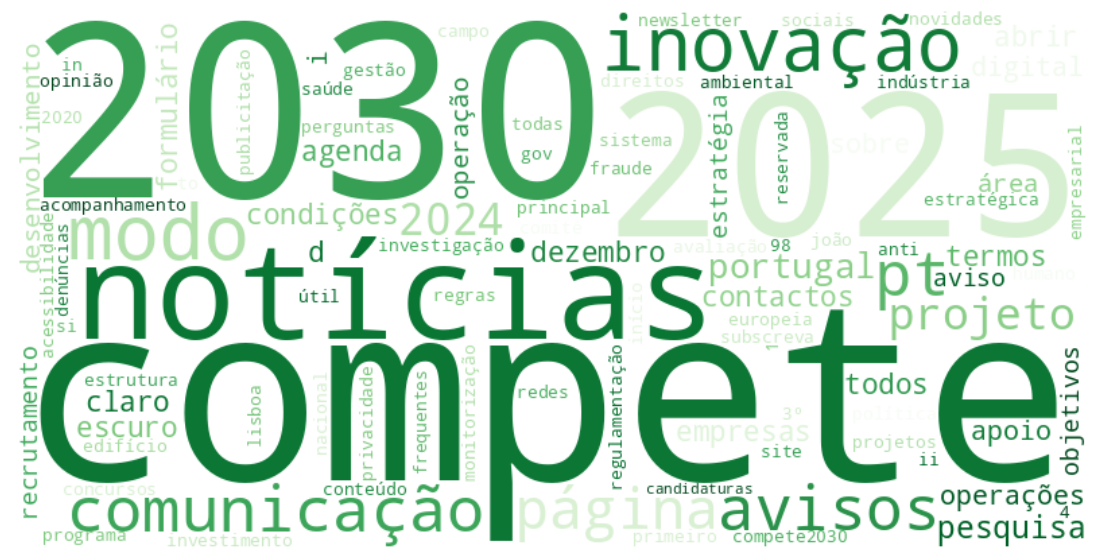

In [51]:
wc = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='Greens'
).generate_from_frequencies(freq_dict_bc)

# plot
plt.figure(figsize=(15, 7))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

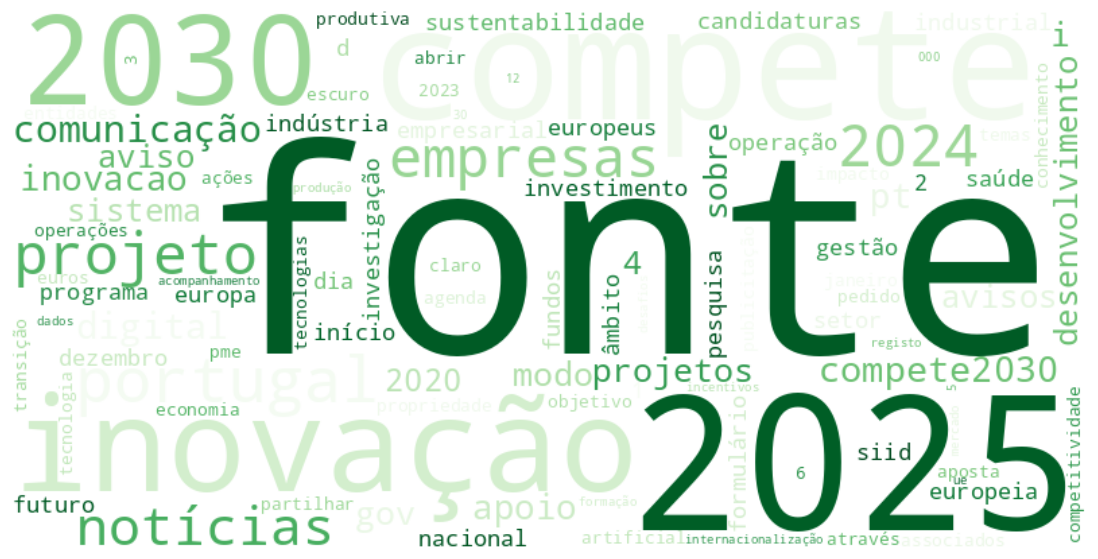

In [52]:
wc = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='Greens'
).generate_from_frequencies(freq_dict_ac)

# plot
plt.figure(figsize=(15, 7))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

In [34]:
def plot_most_common_words(common_words, title="Top 20 Most Common Words"):

    words, counts = zip(*common_words)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(words), y=list(counts))
    plt.xlabel("Frequency")
    plt.ylabel("Word")
    plt.title(title)
    plt.xticks(rotation=45) 
    plt.show()


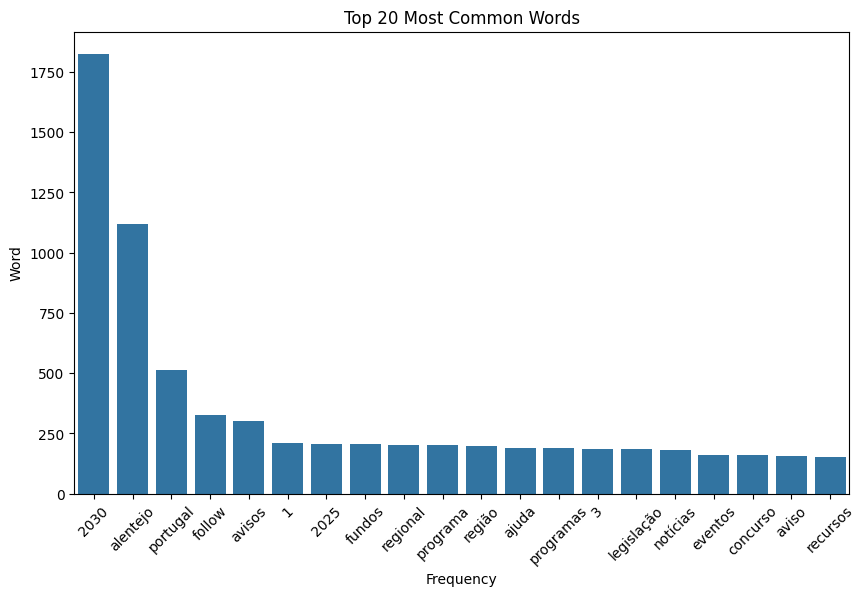

In [35]:
plot_most_common_words(common_words_bc[:20])

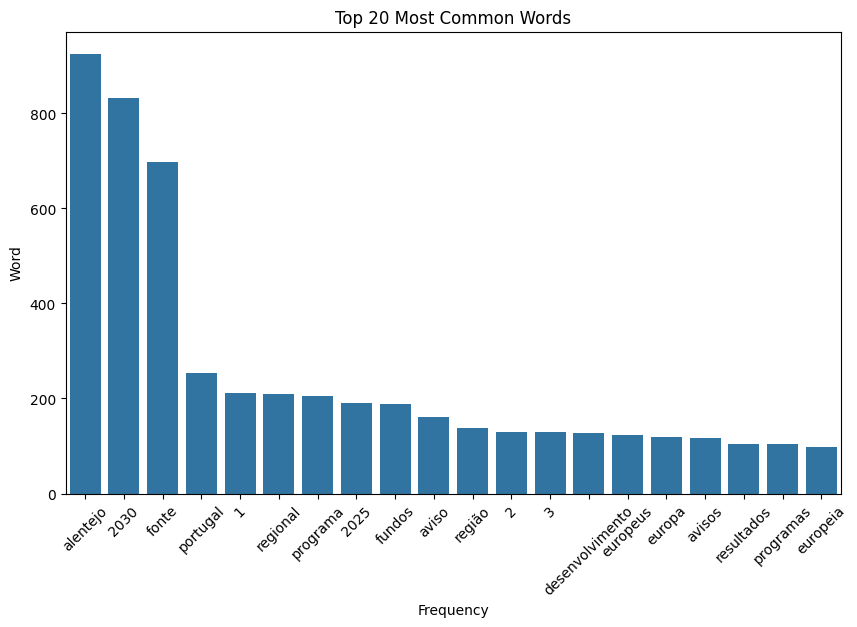

In [36]:
plot_most_common_words(common_words_ac[:20])

# Evaluation Dataset Creation

In [24]:
import json
import pandas as pd
from openai import OpenAI
from dotenv import load_dotenv

load_dotenv()
client = OpenAI()

In [25]:
dfs = {
    file_name: df_file.copy()
    for file_name, df_file in data_ac.groupby("file")
}

In [26]:
dfs.keys()

dict_keys(['alentejo2030', 'algarve2030', 'centro2030', 'compete2030', 'iapmei', 'lisboa2030', 'norte2030', 'portugal2030'])

In [27]:
def generate_qa_from_df(
    df: pd.DataFrame,
    text_column: str,
    model: str = "gpt-4o-mini",
    n_questions: int = 5,
    max_chars: int = 6000
):
    """
    Receives a DataFrame with text and returns n question–answer pairs in JSON format.
    """

    # 1. Prepare text (truncate to avoid context overflow)
    text = "\n\n".join(df[text_column].dropna().astype(str).tolist())
    text = text[:max_chars]

    # 2. Prompt
    prompt = f"""
        És um assistente que cria perguntas e respostas com base na informação fornecida. 
        Sê sempre claro na questão que colocas, garantindo sempre que tem informação suficiente 
        para que seja possível obter uma resposta. Lembra-te de que, no futuro, a busca pela
        resposta será feita relativamente a todos os programas.
        
        Regras:
        - Gera exatamente {n_questions} perguntas e respostas
        - As perguntas devem ser claras e relevantes
        - As respostas devem basear-se apenas na informação disponível e ser o mais completas possível
        - Responde APENAS em JSON válido sempre, independentemente de tudo o resto.
        
        Texto:
        \"\"\"
        {text}
        \"\"\"
        """

    # 3. Call model
    response = client.chat.completions.create(
        model=model,
        messages=[{"role": "system", "content": prompt}],
        temperature=0.2,
        response_format={"type": "json_object"}
    )


    # 4. Parse JSON safely
    content = response.choices[0].message.content.strip()

    try:
        qa = json.loads(content)
    except json.JSONDecodeError as e:
        raise ValueError(f"Model did not return valid JSON:\n{content}") from e

    return qa


In [28]:
all_qa = {}

for file_name, df in dfs.items():
    qa_pairs = generate_qa_from_df(
        df=df,
        text_column="content"
    )
    all_qa[file_name] = qa_pairs

In [12]:
[q["questions"] for q in all_qa["portugal2030"]["questions"]]

['O que é o Portugal 2030 e qual é o seu objetivo?',
 'Quantos milhões de euros já foram pagos aos beneficiários do Portugal 2030?',
 'Quando e onde ocorreu a Mostra dos Fundos Europeus?',
 'Quais são os programas que compõem o Portugal 2030?',
 'Como os interessados podem entrar em contato com a Linha dos Fundos para esclarecer dúvidas?']

In [29]:
all_qa

{'alentejo2030': {'perguntas_e_respostas': [{'pergunta': 'O que é o programa Alentejo 2030?',
    'resposta': 'O Alentejo 2030 é um programa que visa transformar vidas na região do Alentejo, impulsionando a inovação, a sustentabilidade e o crescimento. O programa também oferece oportunidades para beneficiar dos Fundos Europeus disponíveis.'},
   {'pergunta': 'Quais são algumas das novas prioridades específicas integradas na reprogramação do Alentejo 2030?',
    'resposta': 'As novas prioridades incluem a Defesa, a Água, a Habitação a preços acessíveis e sustentável, e as Competências para a descarbonização. Estas áreas focam em tecnologias de dupla utilização, gestão sustentável da água, acesso à habitação e educação voltada para a transição climática.'},
   {'pergunta': 'Quando foi aprovada a reprogramação do Alentejo 2030 pela Comissão Europeia?',
    'resposta': 'A reprogramação do Alentejo 2030 foi aprovada pela Comissão Europeia no dia 15 de dezembro de 2025.'},
   {'pergunta': 'Q

In [30]:
with open("evaluation/evaluation_dataset_v4.json", "w", encoding="utf-8") as f:
    json.dump(
        all_qa,
        f,
        ensure_ascii=False,  # keeps Portuguese accents
        indent=2             # pretty formatting
    )
